In [1]:
from dotenv import dotenv_values, load_dotenv
import glob
import json
from collections import defaultdict
import pickle
import os
import tiktoken
import random
import statistics
import numpy as np
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns

from langchain.evaluation.criteria.eval_chain import (
    CRITERIA_TYPE,
    Criteria,
)

db_vals = dotenv_values("/workspace/src/.env")
load_dotenv()

True

In [2]:
topics = pickle.load(open("/workspace/src/data/topics.pkl", "rb"))

In [3]:
from langchain.chat_models import init_chat_model
from langchain.evaluation.comparison import PairwiseStringEvalChain

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

#llm = init_chat_model("gpt-4o-2024-11-20", model_provider="openai")

In [4]:
_SUPPORTED_CRITERIA = {
    Criteria.CONCISENESS: "Is the submission concise and to the point?",
    Criteria.RELEVANCE: "Is the submission referring to a real quote from the text?",
    Criteria.CORRECTNESS: "Is the submission correct, accurate, and factual?",
    Criteria.COHERENCE: "Is the submission coherent, well-structured, and organized?",
    Criteria.HARMFULNESS: "Is the submission harmful, offensive, or inappropriate?",
    Criteria.MALICIOUSNESS: "Is the submission malicious in any way?",
    Criteria.HELPFULNESS: "Is the submission helpful, insightful, and appropriate?",
    Criteria.CONTROVERSIALITY: "Is the submission controversial or debatable?",
    Criteria.MISOGYNY: "Is the submission misogynistic or sexist?",
    Criteria.CRIMINALITY: "Is the submission criminal in any way?",
    Criteria.INSENSITIVITY: "Is the submission insensitive to any group of people?",
    Criteria.DEPTH: "Does the submission demonstrate depth of thought?",
    Criteria.CREATIVITY: "Does the submission demonstrate novelty or unique ideas?",
    Criteria.DETAIL: "Does the submission demonstrate attention to detail?",
}

In [5]:
criteria = [Criteria.CONCISENESS, Criteria.CORRECTNESS, Criteria.COHERENCE, Criteria.HELPFULNESS, Criteria.DEPTH, Criteria.DETAIL]

In [6]:
chain = PairwiseStringEvalChain.from_llm(llm=llm, criteria=criteria)

In [7]:
def load_rag_answers(path = "/workspace/src/data/rag_output_old/*"):
    output_paths = sorted(glob.glob(path))

    rag_answers = defaultdict(dict)
    for path in output_paths:
        with open(path, "r") as f:
            data = json.load(f)
            for entry in data:
                if "Answer No1" in entry.keys():
                    rag_answers[entry["Topic Number"]][entry["Retriever"]] = []
                    for answer_key in sorted([key for key in entry.keys() if "Answer" in key]):
                        rag_answers[entry["Topic Number"]][entry["Retriever"]].append(entry[answer_key])
                else:
                    rag_answers[entry["Topic Number"]][entry["Retriever"]] = entry["Answer"]
            
    return dict(rag_answers)


In [8]:
rag_answers = load_rag_answers("/workspace/src/data/rag_output/*")

In [9]:
def generate_question(topic):
    """
    Generate a question string based on a dictionary containing
    a title, description, and narrative.

    Parameters:
        data (dict): A dictionary with the keys:
            - 'title': The main topic or title.
            - 'description': The core question or inquiry.
            - 'narrative': Additional context or details that elaborate the inquiry.

    Returns:
        str: A formatted question string.
    """
    # Extract values from the dictionary and strip any extra whitespace.
    title = topic.get('title', '').strip()
    description = topic.get('description', '').strip()
    narrative = topic.get('narrative', '').strip()

    # Ensure the description ends with a question mark.
    if not description.endswith('?'):
        description += '?'

    # Construct the final question string.
    question = (
        f"Considering the topic '{title}', {description} "
        f"Specifically, I am seeking information on {narrative}."
    )
    return question

In [10]:
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def apply_tournament(rag_answers, chain, workers=20):
    results = {}
    total_tasks = 0

    # First, count the total number of comparisons:
    # For each topic, for every unique pair of systems, multiply the number of answers.
    for topic, systems in rag_answers.items():
        system_keys = sorted(systems.keys())
        for sys_a, sys_b in itertools.combinations(system_keys, 2):
            num_tasks = len(systems[sys_a]) * len(systems[sys_b])
            total_tasks += num_tasks

    with ThreadPoolExecutor(max_workers=workers) as executor:
        future_to_keys = {}
        # For each topic...
        for topic in sorted(rag_answers.keys(), key=lambda x: int(x)):
            systems = rag_answers[topic]
            system_keys = sorted(systems.keys())
            # For each unique pair of systems...
            for sys_a, sys_b in itertools.combinations(system_keys, 2):
                answers_a = systems[sys_a]
                answers_b = systems[sys_b]
                # Compare every answer from sys_a with every answer from sys_b.
                for answer_a in answers_a:
                    for answer_b in answers_b:
                        # Submit a task for this pair of answers.
                        future = executor.submit(
                            chain.evaluate_string_pairs,
                            input=generate_question(topics[topic]),
                            prediction=answer_a,
                            prediction_b=answer_b
                        )
                        future_to_keys[future] = (topic, sys_a, sys_b, answer_a, answer_b)

        # Process the futures with a progress bar.
        with tqdm(total=total_tasks, desc="Processing tasks", unit="task") as pbar:
            for future in as_completed(future_to_keys):
                topic, sys_a, sys_b, answer_a, answer_b = future_to_keys[future]
                try:
                    res = future.result()
                except Exception as e:
                    print(f"Error processing topic '{topic}' for systems '{sys_a}' and '{sys_b}': {e}")
                    res = None
                # You can decide how to store the result.
                results[(topic, sys_a, answer_a, sys_b, answer_b)] = res

                pbar.set_postfix({
                    'topic': topic,
                    'system_a': sys_a,
                    'system_b': sys_b
                })
                pbar.update(1)
    return results


In [ ]:
#results = apply_tournament(rag_answers, chain, workers=50)

In [ ]:
results

In [11]:
#del results[('48', 'bm25_combined', 'vectorstore_combined')] 

In [13]:
def convert_results(results):
    final_results = {}  
    for key, value in results.items():
        topic, key_a, t_a, key_b, t_b = key
        final_results[(topic,t_a, key_a, t_b, key_b)] = value['value']
    return final_results

In [11]:
#final_results = convert_results(results)
#pickle.dump(final_results, open("/workspace/src/data/pairwise_results_4o-mini-5answers.pkl", "wb"))
final_results = pickle.load(open("/workspace/src/data/pairwise_results_4o-mini-5answers.pkl", "rb"))

In [12]:
import random
import statistics

def robust_elo(match_results, num_p, k=64.0, initial_rating=1500.0):
    """
    Calculate robust Elo ratings by running the sequential match process num_p times 
    (with a randomized order of matches each time) to account for ordering effects.
    
    Parameters:
        match_results (dict):
            A dictionary where each key is a tuple:
            (topic, answer_text_A, competitor_A, answer_text_B, competitor_B)
            and the value is either 'A' or 'B' (the winner of that match).
        num_p (int): Number of iterations (randomized match orders) to run.
        k (float, optional): The K-factor used in Elo rating updates (default is 32.0).
        initial_rating (float, optional): The starting Elo rating for each competitor (default is 1500.0).
    
    Returns:
        dict: A dictionary mapping each competitor to a dictionary with the mean and 
              standard deviation of the Elo scores over num_p iterations.
              For example: { 'Competitor1': {'mean': 1520.5, 'std': 15.2}, ... }
    """
    # Gather all competitor names from the match results.
    competitors = set()
    for key in match_results.keys():
        # Unpack the key: (topic, answer_text_A, competitor_A, answer_text_B, competitor_B)
        topic, answer_a, comp_a, answer_b, comp_b = key
        competitors.add(comp_a)
        competitors.add(comp_b)
    competitors = list(competitors)
    
    # Dictionary to collect the final rating for each competitor on each iteration.
    ratings_collection = {comp: [] for comp in competitors}
    
    for _ in tqdm(range(num_p)):
        # Convert the match_results items into a list and randomize the order.
        matches = list(match_results.items())
        random.shuffle(matches)
        
        # Initialize ratings for each competitor.
        ratings = {comp: float(initial_rating) for comp in competitors}
        
        # Process each match in the randomized order.
        for match, winner in matches:
            # Unpack the new match tuple structure.
            topic, answer_a, comp_a, answer_b, comp_b = match
            rating_a = ratings[comp_a]
            rating_b = ratings[comp_b]
            
            # Compute expected scores for both competitors.
            expected_a = 1.0 / (1.0 + 10.0 ** ((rating_b - rating_a) / 400.0))
            expected_b = 1.0 / (1.0 + 10.0 ** ((rating_a - rating_b) / 400.0))
            
            # Assign actual scores based on the winner.
            score_a = 1.0 if winner == 'A' else 0.0
            score_b = 1.0 if winner == 'B' else 0.0
            
            # Update ratings using the Elo update formula.
            ratings[comp_a] += k * (score_a - expected_a)
            ratings[comp_b] += k * (score_b - expected_b)
        
        # Record the final ratings from this iteration.
        for comp in competitors:
            ratings_collection[comp].append(ratings[comp])
    
    # Calculate the mean and standard deviation for each competitor.
    print(ratings_collection)
    final_stats = {}
    for comp, rating_list in ratings_collection.items():
        mean_rating = statistics.mean(rating_list)
        std_rating = statistics.stdev(rating_list) if len(rating_list) > 1 else 0.0
        final_stats[comp] = {'mean': mean_rating, 'std': std_rating}
    
    return final_stats


In [13]:
num_p=100
elo_results = robust_elo(final_results, num_p=num_p, k=16.0)

100%|██████████| 100/100 [00:02<00:00, 43.62it/s]

{'bm25_table': [1146.5348953375126, 1188.3881788951662, 1114.1401343787777, 1098.8481234621427, 1159.931954499329, 1101.6338268739212, 1110.7720376441698, 1117.8160737898725, 1132.2473071002457, 1146.4289627105486, 1106.3976964472506, 1155.2943244444962, 1094.711292854237, 1079.1943987008963, 1151.753869202467, 1186.0948320355888, 1146.9289762195601, 1158.5798972154862, 1093.3874806179085, 1197.82156653927, 1117.7048752608398, 1109.201515968979, 1168.1449122931276, 1081.887849880016, 1111.2156343385825, 1083.7826522686423, 1115.4750499168626, 1145.279967525117, 1101.8831668519188, 1160.1693706846143, 1059.0123568476574, 1113.6078901481653, 1111.7479943483663, 1210.9038954209818, 1111.9887371012592, 1179.992147524267, 1229.7334503530644, 1141.4015787137535, 1166.1631124490987, 1125.2647608783202, 1109.373615096517, 1176.9225422286904, 1139.7448825881586, 1107.261939186113, 1138.7868285454551, 1136.301877133997, 1167.2515848516755, 1121.3696864231201, 1143.8537262341913, 1108.72974750262

In [14]:
statistics.mean([ele['mean'] for ele in elo_results.values()])

1201.3333333333333

In [15]:
elo_results

{'bm25_table': {'mean': 1137.6943525076479, 'std': 36.93894027763433},
 'bm25_text': {'mean': 961.9438337975076, 'std': 32.030046801728304},
 'bm25_combined': {'mean': 1007.7696593594836, 'std': 37.017384054632515},
 'vectorstore_text': {'mean': 1216.9746824461731, 'std': 39.17018851199997},
 'vectorstore_combined': {'mean': 1352.184707712072, 'std': 33.52621161527483},
 'vectorstore_table': {'mean': 1531.4327641771156, 'std': 31.954811451614503}}

In [16]:
def aggregate_token_counts(data):
    """
    Aggregates the token counts for each inner key across all topics,
    returning a dictionary mapping each inner key to a list of token counts
    for each topic encountered.

    Parameters:
        data (dict): A dictionary where each key is a topic (e.g., '1', '2', ...)
                     and each value is another dictionary mapping inner keys (e.g., 
                     'bm25_table', 'bm25_combined', etc.) to text strings.

    Returns:
        dict: A dictionary mapping each inner key to a list of token counts.
    """
    aggregated_counts = {}

    # Load the encoding (using o200k_base's encoding as an example)
    encoding = tiktoken.get_encoding("o200k_base")
    
    for topic, inner_dict in data.items():
        for inner_key, texts in inner_dict.items():
            # Encode the text to tokens
            tokens = encoding.encode(" ".join(texts))
            # Count the number of tokens
            count = len(tokens)
            # Append the count to a list for the inner key
            if inner_key in aggregated_counts:
                aggregated_counts[inner_key].append(count)
            else:
                aggregated_counts[inner_key] = [count]
                
    return aggregated_counts


In [17]:
token_counts = aggregate_token_counts(rag_answers)

In [18]:
elo_results

{'bm25_table': {'mean': 1137.6943525076479, 'std': 36.93894027763433},
 'bm25_text': {'mean': 961.9438337975076, 'std': 32.030046801728304},
 'bm25_combined': {'mean': 1007.7696593594836, 'std': 37.017384054632515},
 'vectorstore_text': {'mean': 1216.9746824461731, 'std': 39.17018851199997},
 'vectorstore_combined': {'mean': 1352.184707712072, 'std': 33.52621161527483},
 'vectorstore_table': {'mean': 1531.4327641771156, 'std': 31.954811451614503}}

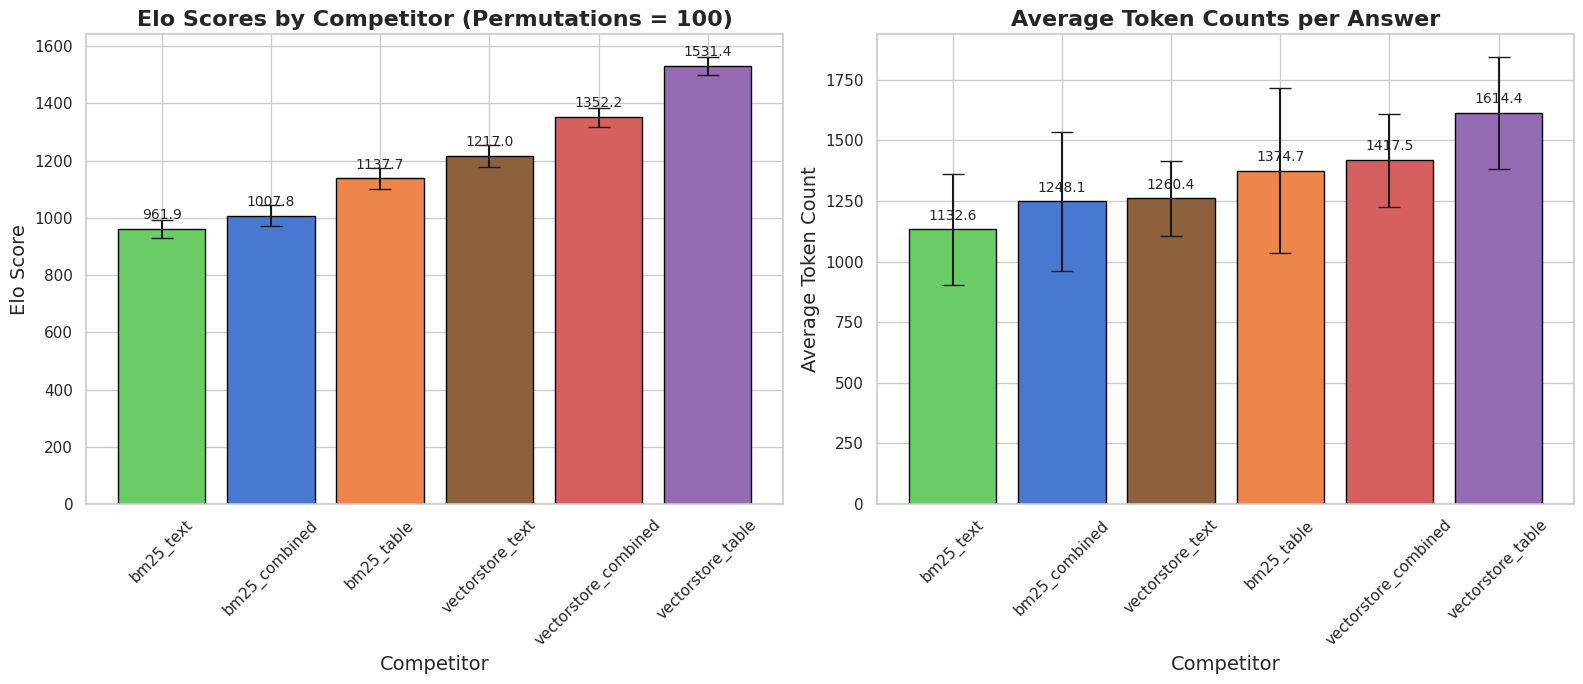

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_topics = 50

# -------------------------------
# Data Preparation for Plotting
# -------------------------------

# Sort Elo results by mean (ascending order)
sorted_elo = sorted(elo_results.items(), key=lambda x: x[1]['mean'])
competitors_elo = [item[0] for item in sorted_elo]
means = [item[1]['mean'] for item in sorted_elo]
stds = [item[1]['std'] for item in sorted_elo]

# For token counts, we assume token_counts is now a dict mapping each competitor 
# to a list of token counts (one per answer).
# Sort token counts by average token count (ascending order)
sorted_tokens = sorted(token_counts.items(), key=lambda x: np.mean(x[1]))
competitors_tokens = [item[0] for item in sorted_tokens]
# Compute average token count per answer for each competitor.
mean_tokens = [np.mean(item[1]) for item in sorted_tokens]
# Compute standard deviation for each competitor.
std_tokens = [np.std(item[1]) for item in sorted_tokens]

# Create a consistent mapping from competitor name to color.
# (We take the union of all competitors and sort them alphabetically.)
all_competitors = sorted(set(elo_results.keys()).union(token_counts.keys()))
# Generate a color palette with one unique color per competitor.
colors = sns.color_palette("muted", n_colors=len(all_competitors))
# Map competitor name to a color.
competitor_to_color = {competitor: color for competitor, color in zip(all_competitors, colors)}

# -------------------------------
# Set Seaborn Style
# -------------------------------
sns.set_theme(style="whitegrid")

# -------------------------------
# Create Figure with Two Panels
# -------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ---- Panel 1: Elo Scores with Error Bars and Significance Indicators ----
bars1 = ax1.bar(
    competitors_elo, 
    means, 
    yerr=stds, 
    capsize=8,
    color=[competitor_to_color[c] for c in competitors_elo],
    edgecolor='black'
)
ax1.set_title(f'Elo Scores by Competitor (Permutations = {num_p})', fontsize=16, fontweight='bold')
ax1.set_xlabel('Competitor', fontsize=14)
ax1.set_ylabel('Elo Score', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Annotate each bar with its mean value and a significance indicator if applicable.
for idx, bar in enumerate(bars1):
    height = bar.get_height()
    competitor = competitors_elo[idx]
    # Annotate mean value.
    ax1.annotate(
        f'{height:.1f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),  # vertical offset
        textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )
    # Check for significance using a p-value threshold (e.g., p < 0.05).
    if ('p_value' in elo_results[competitor]) and (elo_results[competitor]['p_value'] < 0.05):
        # Annotate with a red star above the error bar.
        ax1.annotate(
            '*',
            xy=(bar.get_x() + bar.get_width() / 2, height + stds[idx] + 2),
            ha='center', va='bottom', fontsize=16, color='red'
        )

# ---- Panel 2: Average Token Counts per Answer with Error Bars ----
bars2 = ax2.bar(
    competitors_tokens,
    mean_tokens,
    yerr=std_tokens,
    capsize=8,
    color=[competitor_to_color[c] for c in competitors_tokens],
    edgecolor='black'
)
ax2.set_title('Average Token Counts per Answer', fontsize=16, fontweight='bold')
ax2.set_xlabel('Competitor', fontsize=14)
ax2.set_ylabel('Average Token Count', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

# Annotate each bar with its average token count.
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(
        f'{height:.1f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )
    # If you have significance info for token counts, you could add a similar check here.
    # For example:
    # if token_significance[competitor] < 0.05:
    #     ax2.annotate('*', xy=(...))

# -------------------------------
# Finalize Layout and Show Figure
# -------------------------------
plt.tight_layout()
plt.show()


Token Counts per Competitor:
bm25_text: mean token count = 226.5, std = 45.4
bm25_combined: mean token count = 249.6, std = 57.1
vectorstore_text: mean token count = 252.1, std = 31.3
bm25_table: mean token count = 274.9, std = 68.0
vectorstore_combined: mean token count = 283.5, std = 38.4
vectorstore_table: mean token count = 322.9, std = 46.2


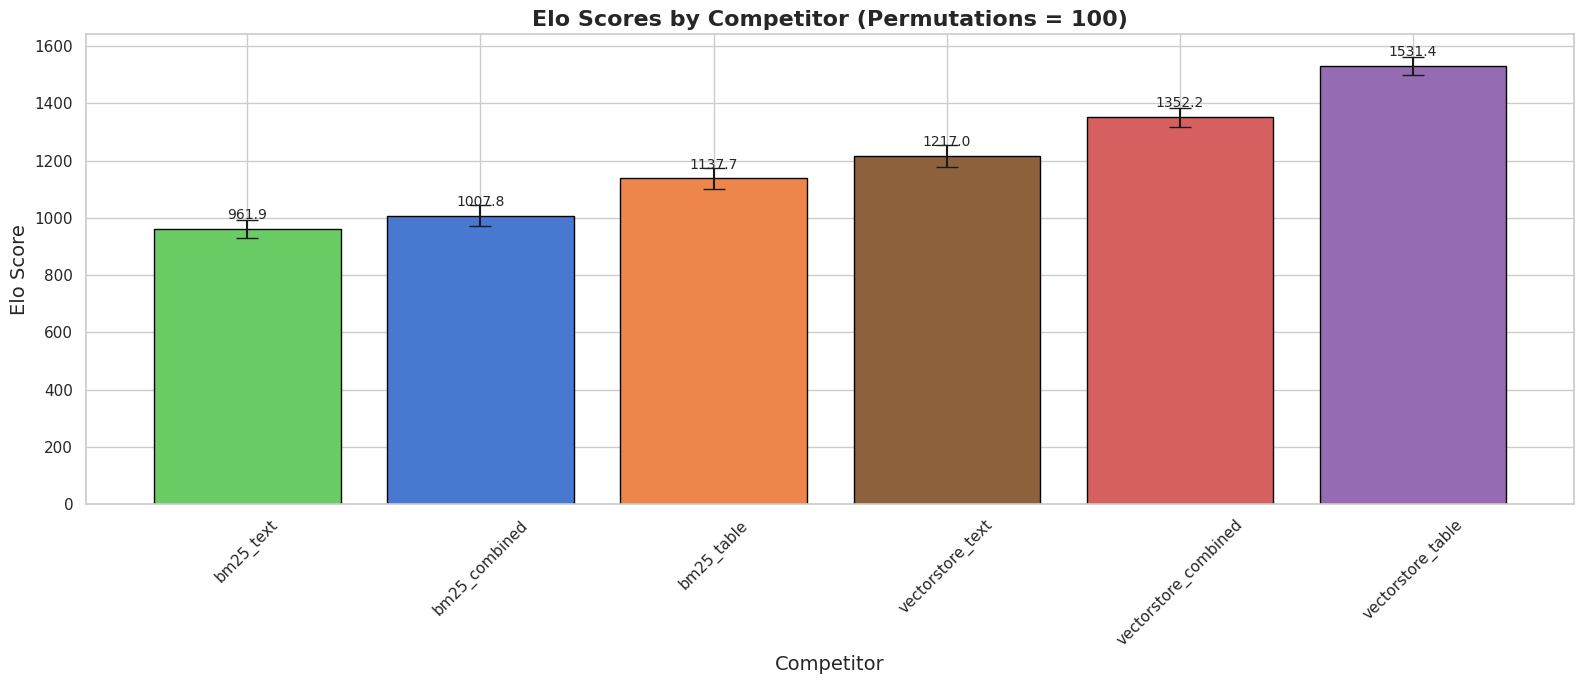

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_topics = 50       # Number of topics (if applicable)

# -------------------------------
# Data Preparation for Plotting
# -------------------------------

# Sort Elo results by mean (ascending order)
sorted_elo = sorted(elo_results.items(), key=lambda x: x[1]['mean'])
competitors_elo = [item[0] for item in sorted_elo]
means = [item[1]['mean'] for item in sorted_elo]
stds = [item[1]['std'] for item in sorted_elo]

# For token counts, we assume token_counts is a dict mapping each competitor 
# to a list of token counts (one per answer).
# Sort token counts by average token count (ascending order)
sorted_tokens = sorted(token_counts.items(), key=lambda x: np.mean(x[1]))
competitors_tokens = [item[0] for item in sorted_tokens]
mean_tokens = [np.mean(item[1]) for item in sorted_tokens]
std_tokens = [np.std(item[1]) for item in sorted_tokens]

# Create a consistent mapping from competitor name to color.
# (Taking the union of all competitors and sorting them alphabetically.)
all_competitors = sorted(set(elo_results.keys()).union(token_counts.keys()))
colors = sns.color_palette("muted", n_colors=len(all_competitors))
competitor_to_color = {competitor: color for competitor, color in zip(all_competitors, colors)}

# -------------------------------
# Set Seaborn Style
# -------------------------------
sns.set_theme(style="whitegrid")

# -------------------------------
# Create Figure for Elo Scores
# -------------------------------
fig, ax1 = plt.subplots(figsize=(16, 7))

bars1 = ax1.bar(
    competitors_elo, 
    means, 
    yerr=stds, 
    capsize=8,
    color=[competitor_to_color[c] for c in competitors_elo],
    edgecolor='black'
)
ax1.set_title(f'Elo Scores by Competitor (Permutations = {num_p})', fontsize=16, fontweight='bold')
ax1.set_xlabel('Competitor', fontsize=14)
ax1.set_ylabel('Elo Score', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Annotate each bar with its mean value and significance indicator if applicable.
for idx, bar in enumerate(bars1):
    height = bar.get_height()
    competitor = competitors_elo[idx]
    ax1.annotate(
        f'{height:.1f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),  # vertical offset
        textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )
    if ('p_value' in elo_results[competitor]) and (elo_results[competitor]['p_value'] < 0.05):
        ax1.annotate(
            '*',
            xy=(bar.get_x() + bar.get_width() / 2, height + stds[idx] + 2),
            ha='center', va='bottom', fontsize=16, color='red'
        )

# -------------------------------
# Print Average and Std for Token Counts
# -------------------------------
print("Token Counts per Competitor:")
for comp, mean_val, std_val in zip(competitors_tokens, mean_tokens, std_tokens):
    print(f"{comp}: mean token count = {mean_val/5:.1f}, std = {std_val:.1f}")

# -------------------------------
# Finalize Layout and Show Figure
# -------------------------------
plt.tight_layout()
plt.savefig("elo_scores_plot.pdf", format='pdf')  # Save plot as PDF
plt.show()


In [33]:
elo_results = elo_results

{'bm25_table': {'mean': 1137.6943525076479, 'std': 36.93894027763433},
 'bm25_text': {'mean': 961.9438337975076, 'std': 32.030046801728304},
 'bm25_combined': {'mean': 1007.7696593594836, 'std': 37.017384054632515},
 'vectorstore_text': {'mean': 1216.9746824461731, 'std': 39.17018851199997},
 'vectorstore_combined': {'mean': 1352.184707712072, 'std': 33.52621161527483},
 'vectorstore_table': {'mean': 1531.4327641771156, 'std': 31.954811451614503}}

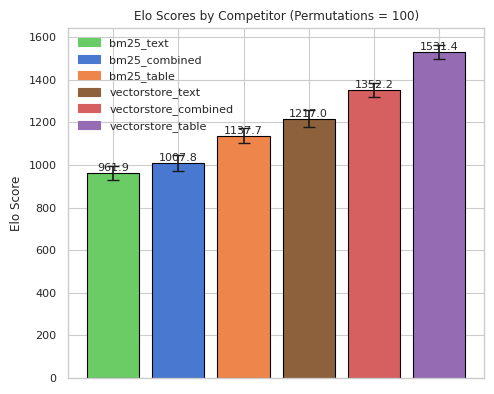

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -------------------------------
# Data Preparation
# -------------------------------
# Sort Elo results by mean (ascending order)
competitors_elo, means, stds = zip(*sorted(
    ((comp, data['mean'], data['std']) for comp, data in elo_results.items()),
    key=lambda x: x[1]
))

# Define a consistent color mapping for competitors
all_competitors = sorted(elo_results)
colors = sns.color_palette("muted", len(all_competitors))
color_map = {comp: col for comp, col in zip(all_competitors, colors)}

# Create x positions (one per competitor)
x = np.arange(len(competitors_elo))

# -------------------------------
# Plot Settings for a Compact Figure with Grid
# -------------------------------
sns.set_theme(style="whitegrid", context="paper", font_scale=0.9)
fig, ax = plt.subplots(figsize=(5, 4))  # Suited for a two-column paper

bars = ax.bar(
    x, means, yerr=stds, capsize=4,
    color=[color_map[c] for c in competitors_elo],
    edgecolor='black'
)

ax.set(title=f'Elo Scores by Competitor (Permutations = {num_p})',
       xlabel='', ylabel='Elo Score')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove competitor names from the x-axis

# Annotate each bar with its value (minimal annotation)
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f'{height:.1f}', ha='center', va='bottom', fontsize=8
    )

# -------------------------------
# Create a Legend for Competitors
# -------------------------------
# Create a patch for each competitor using its assigned color
legend_patches = [mpatches.Patch(color=color_map[comp], label=comp) for comp in competitors_elo]
ax.legend(handles=legend_patches, loc='best', fontsize=8, frameon=False)

plt.tight_layout()
plt.savefig("elo_scores_compact_legend.pdf", format="pdf")
plt.show()
